In [1]:
# Passo 1: Importar a biblioteca pandas
import pandas as pd

# Passo 2: Definir o nome do arquivo de dados
# Este nome DEVE ser idêntico ao arquivo na sua pasta
nome_arquivo_dados = 'Vitigel_2023.xlsx' 

print(f"Tentando carregar o arquivo: {nome_arquivo_dados} ...")
# Isso pode demorar alguns segundos, pois o arquivo é grande
print("Aguarde...")

try:
    # Passo 3: Usar o pandas para ler o arquivo Excel
    # O comando é 'read_excel' pois é um arquivo .xlsx
    df_vigitel_completo = pd.read_excel(nome_arquivo_dados)

    # Passo 4: Se der certo, mostrar uma mensagem e as 5 primeiras linhas
    print("\n✅ Sucesso! Dados carregados.")
    print("Abaixo estão as 5 primeiras linhas da sua tabela (DataFrame):")
    
    # display() é a melhor forma de ver tabelas no Jupyter
    display(df_vigitel_completo.head())

except FileNotFoundError:
    print(f"\n❌ ERRO: Arquivo não encontrado!")
    print(f"Verifique se o nome '{nome_arquivo_dados}' está digitado exatamente igual.")
except Exception as e:
    print(f"\n❌ Ocorreu um erro inesperado: {e}")

Tentando carregar o arquivo: Vitigel_2023.xlsx ...
Aguarde...

✅ Sucesso! Dados carregados.
Abaixo estão as 5 primeiras linhas da sua tabela (DataFrame):


,chave,tipo_fone,replica,cidade,ano,q6,q7,q8a,q8b,q9,...,depressao,ind_med_has,med_has,trat_med_has,ind_med_db,med_db,insulina,trat_med_db,ind_med_depr,trat_med_depr
0,159775260937,CELULAR,12,5,2023,18,1,5,2.0,62,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,459610290826,CELULAR,18,12,2023,23,1,5,2.0,96,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,439521590847,CELULAR,5,4,2023,32,1,4,8.0,93,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,119768260943,CELULAR,15,5,2023,38,1,8,NaN,777,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,349242860840,CELULAR,17,10,2023,42,1,4,8.0,89,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Usar .info() para obter um resumo técnico do DataFrame
print("--- Diagnóstico Completo do DataFrame (df.info) ---")
df_vigitel_completo.info()

--- Diagnóstico Completo do DataFrame (df.info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21690 entries, 0 to 21689
Columns: 233 entries, chave to trat_med_depr
dtypes: float64(113), int64(114), object(6)
memory usage: 38.6+ MB


In [5]:
# Esta célula vai imprimir a lista completa de todos os nomes de colunas
print("--- Lista de TODOS os nomes de colunas no seu DataFrame ---")
lista_de_colunas = df_vigitel_completo.columns.to_list()

print(lista_de_colunas)

--- Lista de TODOS os nomes de colunas no seu DataFrame ---
['chave', 'tipo_fone', 'replica', 'cidade', 'ano', 'q6', 'q7', 'q8a', 'q8b', 'q9', 'q11', 'q12', 'q13', 'q14', 'r190', 'r128a', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31', 'r301_a', 'r301_b', 'r301_c', 'r301_d', 'r301_e', 'r301_f', 'r301_g', 'r301_h', 'r301_i', 'r301_j', 'r301_k', 'r301_l', 'r302_a', 'r302_b', 'r302_c', 'r302_d', 'r302_e', 'r302_f', 'r302_g', 'r302_h', 'r302_i', 'r302_j', 'r302_k', 'r302_l', 'r302_m', 'q35', 'q36', 'q37', 'q38', 'q40', 'q40b', 'q42', 'q43a', 'q43a_ou', 'q44', 'q45', 'q46', 'q47', 'q48', 'q49', 'r147', 'r148_hh', 'r148_mm', 'q50', 'q51', 'q52', 'q53', 'q54', 'q55', 'q56', 'r149', 'r150_hh', 'r150_mm', 'q59a', 'q59b', 'q59c', 'q60', 'q61', 'q61_fx', 'q64', 'q67', 'q68', 'r157', 'r401', 'r401a_1', 'r401b_1', 'r401b_2', 'r401c_1', 'r401c_2', 'r401c_3', 'r402', 'r404', 'r404_ou', 'r403', 'q74', 'q75', 'r203', 'r129', 'q76', 'r204', 'r133a', 'r133b', 'r

In [6]:
# --- CÉLULA 3 (VERSÃO CORRIGIDA) ---
# Nomes de colunas baseados na sua lista de colunas e no dicionário Vigitel

print("Definindo as colunas de interesse para o nosso problema...")

colunas_de_interesse = [
    # Colunas Demográficas e de Filtro:
    'cidade',  # Código da capital (para filtrar Natal/RN)
    'q6',      # Idade
    'q7',      # Sexo
    
    # Coluna sobre Bebida Alcoólica:
    'alcabu',  # Indicador de consumo abusivo de álcool
    
    # Colunas sobre Alimentação:
    'q76',     # Dias por semana que come frutas
    'q82'      # Dias por semana que toma refrigerante
]

print(f"Colunas selecionadas: {colunas_de_interesse}")

try:
    # Passo de "Preparação dos Dados" (página 4 do PDF)
    # Criar um novo DataFrame focado apenas nestas colunas
    df_foco = df_vigitel_completo[colunas_de_interesse].copy()
    
    print("\n✅ Sucesso! DataFrame focado foi criado.")
    print(f"Reduzimos de {df_vigitel_completo.shape[1]} para {df_foco.shape[1]} colunas.")
    display(df_foco.head())

    # "Passo 2: Identificar dados faltantes" (página 41 do PDF)
    print("\n--- Diagnóstico do DataFrame Focado (df_foco.info) ---")
    df_foco.info()

except KeyError as e:
    print(f"\n❌ ERRO DE CHAVE: {e}")
    print("Verifique se TODOS os nomes na lista 'colunas_de_interesse' estão na sua lista de colunas.")

Definindo as colunas de interesse para o nosso problema...
Colunas selecionadas: ['cidade', 'q6', 'q7', 'alcabu', 'q76', 'q82']

✅ Sucesso! DataFrame focado foi criado.
Reduzimos de 233 para 6 colunas.


,cidade,q6,q7,alcabu,q76,q82
0,5,18,1,0,2,NaN
1,12,23,1,0,2,NaN
2,4,32,1,1,2,NaN
3,5,38,1,0,2,NaN
4,10,42,1,0,2,NaN



--- Diagnóstico do DataFrame Focado (df_foco.info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21690 entries, 0 to 21689
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cidade  21690 non-null  int64  
 1   q6      21690 non-null  int64  
 2   q7      21690 non-null  int64  
 3   alcabu  21690 non-null  int64  
 4   q76     21690 non-null  int64  
 5   q82     9412 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 1016.8 KB


In [7]:
# --- CÉLULA 4: TRATAMENTO DOS DADOS FALTANTES ---

# Seguindo o "Passo 5.b: Deletar somente as amostras com dados faltantes" (pág. 41 do PDF)
print(f"Número de linhas ANTES do tratamento: {len(df_foco)}")

# .dropna() remove as linhas que contêm valores nulos (NaN)
# O parâmetro 'subset=['q82']' especifica que o Pandas deve
# olhar APENAS para a coluna 'q82' para decidir qual linha remover.
df_tratado = df_foco.dropna(subset=['q82'])

print(f"Número de linhas DEPOIS de remover os faltantes da 'q82': {len(df_tratado)}")

# --- VERIFICAÇÃO FINAL ---
# Vamos rodar o .info() de novo, agora no nosso DataFrame 'df_tratado'
# A saída deve mostrar que TODAS as colunas agora têm o mesmo número de 'non-null'
print("\n--- Diagnóstico do DataFrame 100% Limpo (df_tratado.info) ---")
df_tratado.info()

Número de linhas ANTES do tratamento: 21690
Número de linhas DEPOIS de remover os faltantes da 'q82': 9412

--- Diagnóstico do DataFrame 100% Limpo (df_tratado.info) ---
<class 'pandas.core.frame.DataFrame'>
Index: 9412 entries, 8135 to 21689
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cidade  9412 non-null   int64  
 1   q6      9412 non-null   int64  
 2   q7      9412 non-null   int64  
 3   alcabu  9412 non-null   int64  
 4   q76     9412 non-null   int64  
 5   q82     9412 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 514.7 KB


In [8]:
# --- CÉLULA 5: FILTRANDO POR LOCALIDADE (NATAL/RN) ---

# O código para a cidade de Natal (RN) no VIGITEL é 24
CODIGO_NATAL = 24

print(f"Filtrando o DataFrame limpo para selecionar apenas os dados de Natal (cidade == {CODIGO_NATAL})...")

# Esta é a operação de filtro:
# df_tratado['cidade'] == CODIGO_NATAL -> cria uma série de True/False
# df_tratado[...] -> seleciona apenas as linhas onde a condição é True
df_natal = df_tratado[df_tratado['cidade'] == CODIGO_NATAL].copy()

print("\n✅ Sucesso! DataFrame 'df_natal' criado.")
print(f"Das {len(df_tratado)} linhas tratadas, {len(df_natal)} são de entrevistas em Natal.")

# --- INSPECIONANDO O RESULTADO FINAL ---
print("\nAbaixo, as 5 primeiras linhas dos dados de Natal (RN):")
display(df_natal.head())

# Vamos verificar a contagem de respostas para a coluna de consumo abusivo de álcool ('alcabu')
print("\nContagem de respostas para 'Consumo Abusivo de Álcool' em Natal:")
print(df_natal['alcabu'].value_counts())

Filtrando o DataFrame limpo para selecionar apenas os dados de Natal (cidade == 24)...

✅ Sucesso! DataFrame 'df_natal' criado.
Das 9412 linhas tratadas, 394 são de entrevistas em Natal.

Abaixo, as 5 primeiras linhas dos dados de Natal (RN):


,cidade,q6,q7,alcabu,q76,q82
8291,24,32,2,0,2,2.0
8299,24,42,2,0,2,1.0
8304,24,34,2,0,2,1.0
8906,24,34,2,0,2,1.0
8931,24,40,2,0,2,3.0



Contagem de respostas para 'Consumo Abusivo de Álcool' em Natal:
alcabu
0    360
1     34
Name: count, dtype: int64


In [9]:
# --- CÉLULA 6: ANÁLISE FINAL - CRUZANDO DADOS ---

# O DataFrame que vamos usar é o 'df_natal', que está limpo e filtrado.

print("--- Análise 1: Consumo Abusivo de Álcool vs. Frequência de Consumo de Frutas ---")

# pd.crosstab() cria a tabela de cruzamento (Tabela de Contingência)
# index: o que vai virar as linhas da tabela (álcool)
# columns: o que vai virar as colunas da tabela (frutas)
tabela_frutas = pd.crosstab(index=df_natal['alcabu'], columns=df_natal['q76'])

# --- TORNANDO A TABELA LEGÍVEL (DECODIFICAÇÃO) ---
# Os resultados '0' e '1' não são intuitivos. Vamos renomeá-los.
# Isso é parte da "Apresentação do resultado"[cite: 34].

# Renomeando o índice (linhas)
tabela_frutas = tabela_frutas.rename(index={
    0: 'Não Consumo Abusivo',
    1: 'Sim Consumo Abusivo'
})

# Renomeando as colunas (cabeçalho)
tabela_frutas.columns.name = 'Dias por Semana (Consumo de Frutas)'

print("\nTabela de Contingência Final:")
display(tabela_frutas)

--- Análise 1: Consumo Abusivo de Álcool vs. Frequência de Consumo de Frutas ---

Tabela de Contingência Final:


Dias por Semana (Consumo de Frutas),1,2
alcabu,,
Não Consumo Abusivo,77,283
Sim Consumo Abusivo,4,30


In [10]:
# --- CÉLULA 7: EXPORTANDO O DATAFRAME FINAL PARA CSV ---

# 1. Definir o nome do nosso novo arquivo CSV
# Ele será salvo na mesma pasta do seu projeto (Projeto_Vitigel)
nome_arquivo_saida = 'dados_vigitel_natal_tratados.csv'

print(f"Tentando salvar o DataFrame 'df_natal' como um arquivo CSV...")
print(f"Nome do arquivo: {nome_arquivo_saida}")

try:
    # 2. Usar o comando .to_csv()
    # index=False: É MUITO importante. Isso evita que o Pandas
    #              salve o índice (8291, 8299, etc.) como uma coluna no CSV.
    # encoding='utf-8': É o padrão universal para planilhas,
    #                  garante que qualquer acento funcione.
    df_natal.to_csv(nome_arquivo_saida, index=False, encoding='utf-8')
    
    print(f"\n✅ Sucesso! O arquivo '{nome_arquivo_saida}' foi criado na sua pasta.")
    print(f"Ele contém as {len(df_natal)} linhas de dados limpos de Natal.")

except Exception as e:
    print(f"\n❌ ERRO ao salvar o arquivo: {e}")

Tentando salvar o DataFrame 'df_natal' como um arquivo CSV...
Nome do arquivo: dados_vigitel_natal_tratados.csv

✅ Sucesso! O arquivo 'dados_vigitel_natal_tratados.csv' foi criado na sua pasta.
Ele contém as 394 linhas de dados limpos de Natal.


In [11]:
# --- CÉLULA 4 (CORRIGIDA) E CÉLULA 5 (CORRIGIDA) ---
# Vamos pular o .dropna() que causou o viés
# E filtrar os dados de Natal diretamente do 'df_foco'

print("--- Correção Metodológica ---")
print("Usando o 'df_foco' original (21.690 linhas) para evitar o viés da coluna 'q82'.")

# O código para a cidade de Natal (RN) no VIGITEL é 24
CODIGO_NATAL = 24

# Filtrando o DataFrame 'df_foco' (o completo) para Natal
df_natal_corrigido = df_foco[df_foco['cidade'] == CODIGO_NATAL].copy()

print(f"\n✅ Sucesso! DataFrame 'df_natal_corrigido' criado.")
print(f"Total de entrevistas em Natal (Homens e Mulheres): {len(df_natal_corrigido)}")

# --- NOVA VERIFICAÇÃO (A PROVA FINAL) ---
print("\n--- Verificação de Sexo ('q7') no DataFrame Corrigido ---")
contagem_sexo_corrigida = df_natal_corrigido['q7'].value_counts().rename(index={1: 'Masculino', 2: 'Feminino'})
print(contagem_sexo_corrigida)

print("\n--- Verificação de Álcool ('alcabu') no DataFrame Corrigido ---")
contagem_alcabu_corrigida = df_natal_corrigido['alcabu'].value_counts().rename(index={0: 'Não', 1: 'Sim'})
print(contagem_alcabu_corrigida)

--- Correção Metodológica ---
Usando o 'df_foco' original (21.690 linhas) para evitar o viés da coluna 'q82'.

✅ Sucesso! DataFrame 'df_natal_corrigido' criado.
Total de entrevistas em Natal (Homens e Mulheres): 800

--- Verificação de Sexo ('q7') no DataFrame Corrigido ---
q7
Feminino     510
Masculino    290
Name: count, dtype: int64

--- Verificação de Álcool ('alcabu') no DataFrame Corrigido ---
alcabu
Não    679
Sim    121
Name: count, dtype: int64


In [12]:
# --- CÉLULA 6 (VERSÃO CORRIGIDA): ANÁLISE FINAL ---

# O DataFrame que vamos usar é o 'df_natal_corrigido'

print("--- Análise Final: Consumo de Álcool vs. Consumo de Frutas em Natal (Amostra Corrigida) ---")

# Criando a Tabela de Contingência (cruzamento)
tabela_cruzada_final = pd.crosstab(
    index=df_natal_corrigido['alcabu'], 
    columns=df_natal_corrigido['q76']
)

# --- Decodificando a Tabela para Melhor Apresentação ---

# Renomeando o índice (linhas) para ficar legível
tabela_cruzada_final = tabela_cruzada_final.rename(index={
    0: 'Não Consumo Abusivo',
    1: 'Sim Consumo Abusivo'
})

# Renomeando o cabeçalho das colunas
tabela_cruzada_final.columns.name = 'Dias por Semana (Consumo de Frutas)'

print("\nTabela de Contingência Final:")
display(tabela_cruzada_final)

--- Análise Final: Consumo de Álcool vs. Consumo de Frutas em Natal (Amostra Corrigida) ---

Tabela de Contingência Final:


Dias por Semana (Consumo de Frutas),1,2
alcabu,,
Não Consumo Abusivo,126,553
Sim Consumo Abusivo,7,114


In [13]:
# --- CÉLULA DE SELEÇÃO ESTRATÉGICA DE VARIÁVEIS ---

print("Definindo as colunas estratégicas para a análise 'Imposto do Pecado vs. Segurança Alimentar'...")

colunas_estrategicas = [
    # Demografia e Filtro:
    'cidade',  # Código da capital
    'q6',      # Idade
    'q7',      # Sexo

    # === Indicadores do 'Imposto do Pecado' ===
    'fumante',          # Indicador de tabagismo (Alvo 1)
    'alcabu',           # Consumo abusivo de álcool (Alvo 2)
    'score_upp_2cat',   # ALVO PRINCIPAL: Consumo de ultraprocessados (Alto/Baixo)
    'q82',              # Consumo de refrigerante (Alvo 4 - CUIDADO COM O VIÉS)

    # === Indicadores de Segurança Alimentar (Dieta Saudável) ===
    'flvreg',           # Consumo regular de Frutas, Legumes e Verduras
    'feijao5'           # Consumo de feijão em 5+ dias/semana
]

print(f"Colunas selecionadas: {colunas_estrategicas}")

try:
    # Criar um novo DataFrame focado
    df_foco_estrategico = df_vigitel_completo[colunas_estrategicas].copy()
    
    print("\n✅ Sucesso! DataFrame estratégico foi criado.")
    display(df_foco_estrategico.head())

    # Diagnóstico para identificar dados faltantes neste novo conjunto
    print("\n--- Diagnóstico do DataFrame Estratégico ---")
    df_foco_estrategico.info()

except KeyError as e:
    print(f"\n❌ ERRO DE CHAVE: {e}")
    print("Verifique se algum nome na lista 'colunas_estrategicas' está incorreto.")

Definindo as colunas estratégicas para a análise 'Imposto do Pecado vs. Segurança Alimentar'...
Colunas selecionadas: ['cidade', 'q6', 'q7', 'fumante', 'alcabu', 'score_upp_2cat', 'q82', 'flvreg', 'feijao5']

✅ Sucesso! DataFrame estratégico foi criado.


,cidade,q6,q7,fumante,alcabu,score_upp_2cat,q82,flvreg,feijao5
0,5,18,1,0,0,0,NaN,0,1
1,12,23,1,0,0,1,NaN,0,1
2,4,32,1,0,1,0,NaN,0,0
3,5,38,1,1,0,0,NaN,0,1
4,10,42,1,0,0,0,NaN,0,1



--- Diagnóstico do DataFrame Estratégico ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21690 entries, 0 to 21689
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cidade          21690 non-null  int64  
 1   q6              21690 non-null  int64  
 2   q7              21690 non-null  int64  
 3   fumante         21690 non-null  int64  
 4   alcabu          21690 non-null  int64  
 5   score_upp_2cat  21690 non-null  int64  
 6   q82             9412 non-null   float64
 7   flvreg          21690 non-null  int64  
 8   feijao5         21690 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 1.5 MB


In [15]:
# --- CÉLULA DE TRATAMENTO FINAL E FILTRO POR LOCALIDADE (CORRIGIDA) ---

print("--- Decisão de Tratamento (Metodologia PDF, pág. 41) ---")
print("A coluna 'q82' (refrigerante) tem 12.278 dados faltantes e introduz viés.")
print("Vamos aplicar a 'Opção (a): Deletar a variável', pois temos indicadores melhores e completos.")

# 1. Tratamento: Deletar a coluna 'q82'
# 'axis=1' informa ao pandas que queremos deletar uma COLUNA, não uma linha.
df_limpo_final = df_foco_estrategico.drop('q82', axis=1)

print("\n✅ DataFrame tratado (sem 'q82'). Verificando .info() rápido:")
print(f"Linhas: {len(df_limpo_final)}, Colunas: {len(df_limpo_final.columns)}")

# 2. Filtragem: Selecionar apenas Natal (RN)
CODIGO_NATAL = 24
df_natal_final = df_limpo_final[df_limpo_final['cidade'] == CODIGO_NATAL].copy()

print(f"\n✅ Sucesso! DataFrame 'df_natal_final' criado.")
print(f"Amostra final e completa para Natal (RN): {len(df_natal_final)} entrevistas.")

# 3. Verificação Final (Garantindo que o viés de sexo foi corrigido)
print("\n--- Verificação de Sexo ('q7') no DataFrame Final ---")
# .rename() para decodificar 1=Masculino, 2=Feminino
contagem_sexo_final = df_natal_final['q7'].value_counts().rename(index={1: 'Masculino', 2: 'Feminino'})
print(contagem_sexo_final)

--- Decisão de Tratamento (Metodologia PDF, pág. 41) ---
A coluna 'q82' (refrigerante) tem 12.278 dados faltantes e introduz viés.
Vamos aplicar a 'Opção (a): Deletar a variável', pois temos indicadores melhores e completos.

✅ DataFrame tratado (sem 'q82'). Verificando .info() rápido:
Linhas: 21690, Colunas: 8

✅ Sucesso! DataFrame 'df_natal_final' criado.
Amostra final e completa para Natal (RN): 800 entrevistas.

--- Verificação de Sexo ('q7') no DataFrame Final ---
q7
Feminino     510
Masculino    290
Name: count, dtype: int64


In [16]:
# --- CÉLULA DE ANÁLISE ESTRATÉGICA FINAL ---

# O DataFrame que vamos usar é o 'df_natal_final', que está limpo, sem viés e focado em Natal.

print("--- Análise Estratégica: Consumo de Ultraprocessados vs. Consumo de Hortaliças em Natal ---")

# Criando a Tabela de Contingência
# index = o que será as linhas
# columns = o que será as colunas
tabela_estrategica = pd.crosstab(
    index=df_natal_final['score_upp_2cat'], 
    columns=df_natal_final['flvreg']
)

# --- Decodificando a Tabela para uma Apresentação Clara (Metadados) ---

# Renomeando o índice (linhas) para ficar legível
# Com base no dicionário, 'score_upp_2cat': 0=Baixo Consumo, 1=Alto Consumo
tabela_estrategica = tabela_estrategica.rename(index={
    0: 'Baixo Consumo de Ultraprocessados',
    1: 'Alto Consumo de Ultraprocessados'
})

# Renomeando as colunas para ficar legível
# Com base no dicionário, 'flvreg': 0=Não, 1=Sim
tabela_estrategica = tabela_estrategica.rename(columns={
    0: 'Não Consome Hortaliças Regularmente',
    1: 'Sim, Consome Hortaliças Regularmente'
})

print("\nTabela de Contingência Final (Contagem Absoluta):")
display(tabela_estrategica)

# --- BÔNUS: Análise Percentual ---
# 'normalize="index"' calcula a porcentagem por linha.
# Isso responde: "Dentro do grupo de 'Alto Consumo', qual a % que consome/não consome hortaliças?"
tabela_percentual = pd.crosstab(
    index=df_natal_final['score_upp_2cat'], 
    columns=df_natal_final['flvreg'],
    normalize='index'
).mul(100).round(2) # .mul(100).round(2) para formatar como porcentagem

# Renomeando para clareza
tabela_percentual = tabela_percentual.rename(index={0: 'Baixo Consumo de Ultraprocessados', 1: 'Alto Consumo de Ultraprocessados'})
tabela_percentual = tabela_percentual.rename(columns={0: '% Não Consome Hortaliças', 1: '% Sim, Consome Hortaliças'})

print("\nTabela de Contingência (Análise Percentual por Linha %):")
display(tabela_percentual)

--- Análise Estratégica: Consumo de Ultraprocessados vs. Consumo de Hortaliças em Natal ---

Tabela de Contingência Final (Contagem Absoluta):


flvreg,Não Consome Hortaliças Regularmente,"Sim, Consome Hortaliças Regularmente"
score_upp_2cat,,
Baixo Consumo de Ultraprocessados,403,271
Alto Consumo de Ultraprocessados,89,37



Tabela de Contingência (Análise Percentual por Linha %):


flvreg,% Não Consome Hortaliças,"% Sim, Consome Hortaliças"
score_upp_2cat,,
Baixo Consumo de Ultraprocessados,59.79,40.21
Alto Consumo de Ultraprocessados,70.63,29.37


In [17]:
# Fumantes consomem mais ultraprocessados?
tabela_fumo = pd.crosstab(
    index=df_natal_final['fumante'], 
    columns=df_natal_final['score_upp_2cat']
)
print("--- Fumo vs. Ultraprocessados (0=Não Fuma, 1=Fuma) ---")
display(tabela_fumo)

--- Fumo vs. Ultraprocessados (0=Não Fuma, 1=Fuma) ---


score_upp_2cat,0,1
fumante,,
0,605,108
1,69,18


In [18]:
# Pessoas com consumo abusivo de álcool comem mais ultraprocessados?
tabela_alcool = pd.crosstab(
    index=df_natal_final['alcabu'], 
    columns=df_natal_final['score_upp_2cat']
)
print("\n--- Álcool Abusivo vs. Ultraprocessados (0=Não, 1=Sim) ---")
display(tabela_alcool)


--- Álcool Abusivo vs. Ultraprocessados (0=Não, 1=Sim) ---


score_upp_2cat,0,1
alcabu,,
0,582,97
1,92,29


In [19]:
# --- Análise Percentual: Fumo vs. Ultraprocessados ---
tabela_fumo_perc = pd.crosstab(
    index=df_natal_final['fumante'], 
    columns=df_natal_final['score_upp_2cat'],
    normalize='index'
).mul(100).round(2)

print("--- Fumo vs. Ultraprocessados (% por linha) ---")
display(tabela_fumo_perc)

# --- Análise Percentual: Álcool vs. Ultraprocessados ---
tabela_alcool_perc = pd.crosstab(
    index=df_natal_final['alcabu'], 
    columns=df_natal_final['score_upp_2cat'],
    normalize='index'
).mul(100).round(2)

print("\n--- Álcool Abusivo vs. Ultraprocessados (% por linha) ---")
display(tabela_alcool_perc)

--- Fumo vs. Ultraprocessados (% por linha) ---


score_upp_2cat,0,1
fumante,,
0,84.85,15.15
1,79.31,20.69



--- Álcool Abusivo vs. Ultraprocessados (% por linha) ---


score_upp_2cat,0,1
alcabu,,
0,85.71,14.29
1,76.03,23.97


In [21]:
# --- CÉLULA DE ESTATÍSTICA DESCRITIVA ---
import pandas as pd # Importar pandas caso seja um novo notebook
import matplotlib.pyplot as plt # Importar a biblioteca de visualização

# Se você parou e voltou, pode precisar recarregar o df_natal_final.
# Por segurança, vamos incluir o código para criá-lo novamente.
# df_natal_final = ... (código das células anteriores para criar o df_natal_final)

print("--- Estatísticas Descritivas para a Idade ('q6') em Natal ---")

# O método .describe() calcula média, mediana (50%), min, max, etc.
estatisticas_idade = df_natal_final['q6'].describe()
display(estatisticas_idade)

print("\n--- Contagens para Variáveis Categóricas (para o Gráfico de Barras) ---")

# Contagem de Fumantes
contagem_fumo = df_natal_final['fumante'].value_counts().rename(index={0: 'Não Fuma', 1: 'Fuma'})
print("\nContagem de Fumantes:")
print(contagem_fumo)

# Contagem de Consumo Abusivo de Álcool
contagem_alcool = df_natal_final['alcabu'].value_counts().rename(index={0: 'Não Abusivo', 1: 'Sim Abusivo'})
print("\nContagem de Consumo de Álcool:")
print(contagem_alcool)

--- Estatísticas Descritivas para a Idade ('q6') em Natal ---


count    800.000000
mean      52.278750
std       18.122474
min       18.000000
25%       37.000000
50%       52.000000
75%       67.000000
max       92.000000
Name: q6, dtype: float64


--- Contagens para Variáveis Categóricas (para o Gráfico de Barras) ---

Contagem de Fumantes:
fumante
Não Fuma    713
Fuma         87
Name: count, dtype: int64

Contagem de Consumo de Álcool:
alcabu
Não Abusivo    679
Sim Abusivo    121
Name: count, dtype: int64


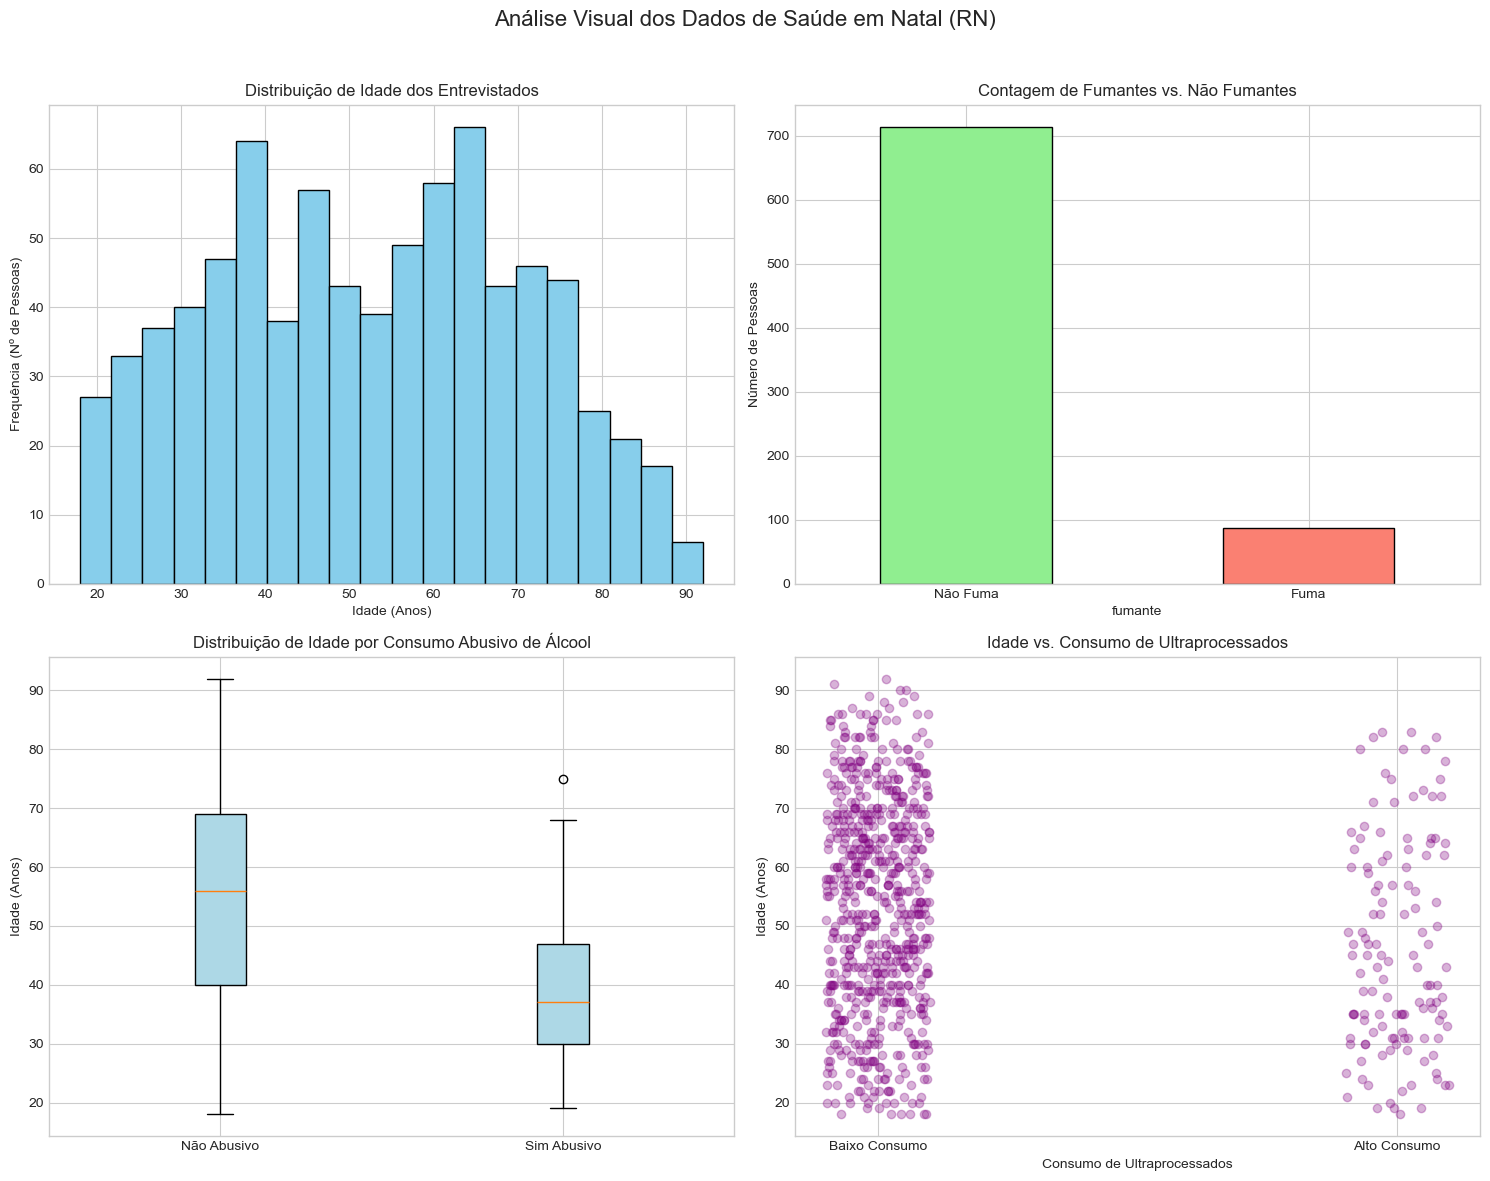

In [22]:
# --- CÉLULA DE VISUALIZAÇÃO DE DADOS COM MATPLOTLIB ---

# Configuração geral para os gráficos ficarem mais bonitos
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(15, 12)) # Cria uma grade de 2x2 para os 4 gráficos
fig.suptitle('Análise Visual dos Dados de Saúde em Natal (RN)', fontsize=16)

# --- 1. Histograma da Idade ('q6') ---
# (Página 143 do seu PDF) - Ótimo para ver a distribuição de uma variável numérica
axs[0, 0].hist(df_natal_final['q6'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribuição de Idade dos Entrevistados')
axs[0, 0].set_xlabel('Idade (Anos)')
axs[0, 0].set_ylabel('Frequência (Nº de Pessoas)')

# --- 2. Gráfico de Barras: Contagem de Fumantes ---
# (Página 126 do seu PDF) - Perfeito para comparar categorias
contagem_fumo.plot(kind='bar', ax=axs[0, 1], color=['lightgreen', 'salmon'], edgecolor='black')
axs[0, 1].set_title('Contagem de Fumantes vs. Não Fumantes')
axs[0, 1].set_ylabel('Número de Pessoas')
axs[0, 1].tick_params(axis='x', rotation=0) # Deixa os rótulos (Não Fuma, Fuma) na horizontal

# --- 3. Boxplot: Idade por Consumo Abusivo de Álcool ---
# (Página 148 do seu PDF) - Excelente para comparar a distribuição de uma variável numérica entre diferentes grupos
dados_boxplot = [
    df_natal_final[df_natal_final['alcabu'] == 0]['q6'], # Idades de quem NÃO tem consumo abusivo
    df_natal_final[df_natal_final['alcabu'] == 1]['q6']  # Idades de quem SIM tem consumo abusivo
]
axs[1, 0].boxplot(dados_boxplot, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1, 0].set_title('Distribuição de Idade por Consumo Abusivo de Álcool')
axs[1, 0].set_xticklabels(['Não Abusivo', 'Sim Abusivo'])
axs[1, 0].set_ylabel('Idade (Anos)')

# --- 4. Gráfico de Dispersão (Scatter Plot): Idade vs. Alto Consumo de Ultraprocessados ---
# (Página 145 do seu PDF) - Usado para ver a relação entre duas variáveis numéricas.
# Como 'score_upp_2cat' é categórico (0 ou 1), o gráfico não é ideal, mas podemos adaptá-lo.
# Vamos adicionar um "jitter" (pequeno ruído aleatório) para os pontos não se sobreporem.
import numpy as np
x_jitter = df_natal_final['score_upp_2cat'] + np.random.rand(len(df_natal_final)) * 0.2 - 0.1
axs[1, 1].scatter(x_jitter, df_natal_final['q6'], alpha=0.3, color='purple')
axs[1, 1].set_title('Idade vs. Consumo de Ultraprocessados')
axs[1, 1].set_xlabel('Consumo de Ultraprocessados')
axs[1, 1].set_xticks([0, 1]) # Força os marcadores a serem 0 e 1
axs[1, 1].set_xticklabels(['Baixo Consumo', 'Alto Consumo'])
axs[1, 1].set_ylabel('Idade (Anos)')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o espaçamento
plt.show()

Criando um gráfico de dispersão mais estratégico: Idade vs. IMC...
Amostra final para o gráfico de dispersão (Idade vs IMC): 744 pessoas.


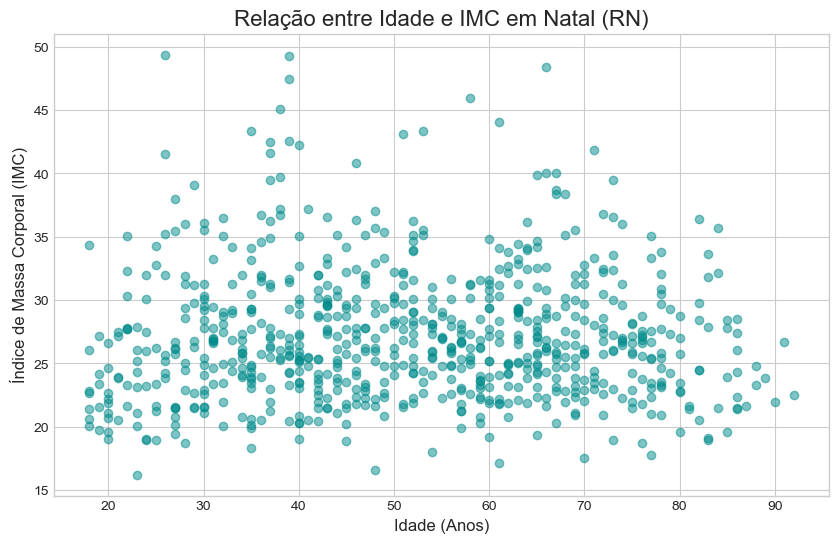

In [24]:
# --- CÉLULA PARA UM GRÁFICO DE DISPERSÃO ESTRATÉGICO ---
import matplotlib.pyplot as plt
import pandas as pd

print("Criando um gráfico de dispersão mais estratégico: Idade vs. IMC...")

# 1. Selecionar as colunas necessárias do DataFrame original e completo
colunas_imc = ['cidade', 'q6', 'imc']
df_para_dispersao = df_vigitel_completo[colunas_imc].copy()

# 2. Filtrar apenas para Natal (RN)
CODIGO_NATAL = 24
df_natal_imc = df_para_dispersao[df_para_dispersao['cidade'] == CODIGO_NATAL].copy()

# 3. TRATAMENTO: A coluna 'imc' pode ter valores nulos ou irreais (ex: 999)
# Vamos remover valores nulos e filtrar por um IMC plausível (entre 10 e 60)
df_natal_imc.dropna(subset=['imc'], inplace=True)
df_natal_imc = df_natal_imc[(df_natal_imc['imc'] > 10) & (df_natal_imc['imc'] < 60)]

print(f"Amostra final para o gráfico de dispersão (Idade vs IMC): {len(df_natal_imc)} pessoas.")

# 4. Plotagem do Gráfico de Dispersão
plt.figure(figsize=(10, 6)) # Cria uma nova figura para o gráfico
plt.scatter(
    df_natal_imc['q6'],      # Eixo X: Idade
    df_natal_imc['imc'],     # Eixo Y: IMC
    alpha=0.5,               # Transparência para ver a densidade dos pontos
    color='darkcyan'
)

plt.title('Relação entre Idade e IMC em Natal (RN)', fontsize=16)
plt.xlabel('Idade (Anos)', fontsize=12)
plt.ylabel('Índice de Massa Corporal (IMC)', fontsize=12)
plt.grid(True)
plt.show()

In [25]:
# --- CÉLULA FINAL: SALVANDO O DATAFRAME TRATADO E CORRIGIDO ---

# 1. Definir o nome do arquivo de saída.
# Vamos usar um nome novo e claro para evitar confusão com o antigo.
# Ou, se preferir, pode usar o MESMO nome do antigo para substituí-lo.
# Vamos usar um nome novo por segurança:
nome_arquivo_corrigido = 'dados_vigitel_natal_FINAL_800.csv'

# (Opcional: Se quiser substituir o arquivo exato que você criou antes)
# nome_arquivo_corrigido = 'dados_vigitel_natal_tratados.csv' 

print(f"Tentando salvar o DataFrame 'df_natal_final' (com {len(df_natal_final)} linhas corrigidas)...")
print(f"Nome do novo arquivo: {nome_arquivo_corrigido}")

try:
    # 2. Usar o comando .to_csv()
    # df_natal_final: É o DataFrame que corrigimos, com 800 linhas (homens e mulheres).
    # index=False: Impede que o Pandas salve o índice do DataFrame como uma coluna.
    # encoding='utf-8': Garante compatibilidade total com o Google Sheets.
    
    df_natal_final.to_csv(nome_arquivo_corrigido, index=False, encoding='utf-8')
    
    print(f"\n✅ Sucesso! O arquivo CORRIGIDO '{nome_arquivo_corrigido}' foi criado na sua pasta.")
    print("Este arquivo contém os dados de 800 entrevistas e 8 colunas estratégicas.")
    print("O viés de amostragem foi removido.")

except Exception as e:
    print(f"\n❌ ERRO ao salvar o arquivo: {e}")

Tentando salvar o DataFrame 'df_natal_final' (com 800 linhas corrigidas)...
Nome do novo arquivo: dados_vigitel_natal_FINAL_800.csv

✅ Sucesso! O arquivo CORRIGIDO 'dados_vigitel_natal_FINAL_800.csv' foi criado na sua pasta.
Este arquivo contém os dados de 800 entrevistas e 8 colunas estratégicas.
O viés de amostragem foi removido.


In [31]:
# --- CÉLULA DE DIAGNÓSTICO: LISTAR ARQUIVOS NA PASTA ATUAL ---
import os

print("--- Arquivos encontrados na pasta do seu projeto ---")

# os.listdir('.') lista todos os arquivos e pastas no diretório atual ('.')
lista_de_arquivos = os.listdir('.')

for nome_arquivo in lista_de_arquivos:
    print(nome_arquivo)

print("\n----------------------------------------------------")
print("Copie o nome EXATO do seu arquivo de dicionário CSV da lista acima e cole na próxima célula.")

--- Arquivos encontrados na pasta do seu projeto ---
.ipynb_checkpoints
analise_visual_natal.png
barras_fumantes.png
boxplot_idade_sexo.png
dados_vigitel_natal_FINAL_800.csv
dados_vigitel_natal_tratados.csv
Dicionario_Dados_Vitigel.xls
dispersao_idade_imc.png
histograma_idade.png
Projeto_Vitigel.ipynb
Vitigel_2023.xlsx

----------------------------------------------------
Copie o nome EXATO do seu arquivo de dicionário CSV da lista acima e cole na próxima célula.


In [32]:
!pip install xlrd

In [36]:
# --- CÉLULA DE DIAGNÓSTICO DE ARQUIVO ---
import pandas as pd

nome_arquivo = 'dados_vitigel_natal - dados_vigitel_natal.csv'

try:
    df_atual = pd.read_csv(nome_arquivo)
    
    print(f"--- Colunas encontradas no arquivo '{nome_arquivo}' ---")
    print(df_atual.columns.to_list())
    
    print("\n--- 5 Primeiras Linhas ---")
    display(df_atual.head())

except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")

--- Colunas encontradas no arquivo 'dados_vitigel_natal - dados_vigitel_natal.csv' ---
['cidade', 'idade', 'sexo', 'fumante', 'alcool_abuso', 'ultrapro', 'frutas_legumes_verduras_regular', 'feijao_5_ou_mais_dias_sem']

--- 5 Primeiras Linhas ---


,cidade,idade,sexo,fumante,alcool_abuso,ultrapro,frutas_legumes_verduras_regular,feijao_5_ou_mais_dias_sem
0,24,40,1,0,0,0,0,1
1,24,24,1,0,0,1,0,1
2,24,32,1,0,1,0,0,0
3,24,35,1,0,1,0,1,0
4,24,32,1,0,1,0,0,1


DataFrame 'df_natal_final' (com 800 linhas) encontrado na memória.
Decodificando as variáveis categóricas...

--- 2.1: Medidas de Posição Central e Dispersão (para 'Idade') ---


count    800.000000
mean      52.278750
std       18.122474
min       18.000000
25%       37.000000
50%       52.000000
75%       67.000000
max       92.000000
Name: q6, dtype: float64


--- 2.2: Tabela de Frequência (para 'Consumo Abusivo de Álcool') ---
alcabu_desc
Não Abusivo    679
Sim Abusivo    121
Name: count, dtype: int64

--- 2.3: Tabela de Frequência (para 'Consumo de Ultraprocessados') ---
upp_desc
Baixo Consumo UP    674
Alto Consumo UP     126
Name: count, dtype: int64

--- 3.1: Gerando Histograma (Idade) ---
Salvo como 'histograma_idade_final.png'

--- 3.2: Gerando Gráfico de Barras (Consumo de Álcool) ---
Salvo como 'barras_alcool_final.png'

--- 3.3: Gerando Boxplot (Idade vs. Consumo de Álcool) ---
Salvo como 'boxplot_idade_vs_alcool.png'

Análise quantitativa concluída com sucesso.


C:\Users\jadson.chagas.102\AppData\Local\Temp\ipykernel_11476\3954617460.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados_boxplot, labels=['Não Abusivo', 'Sim Abusivo'], patch_artist=True,


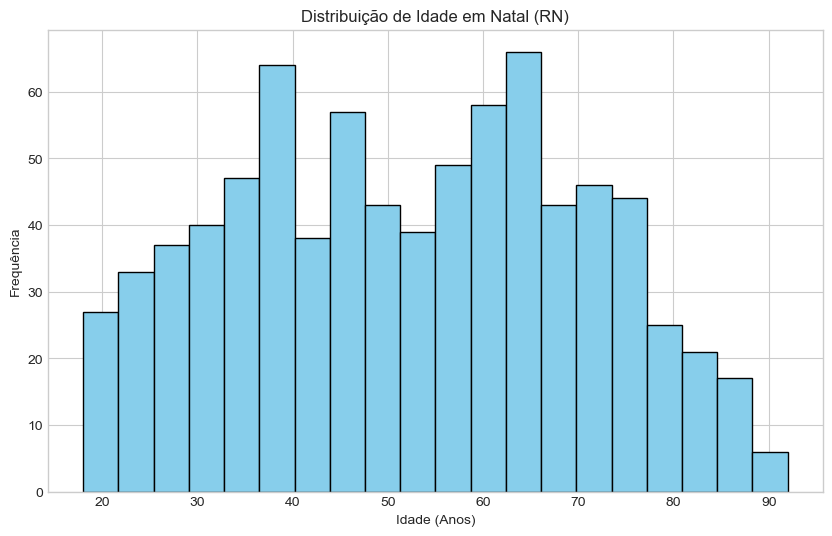

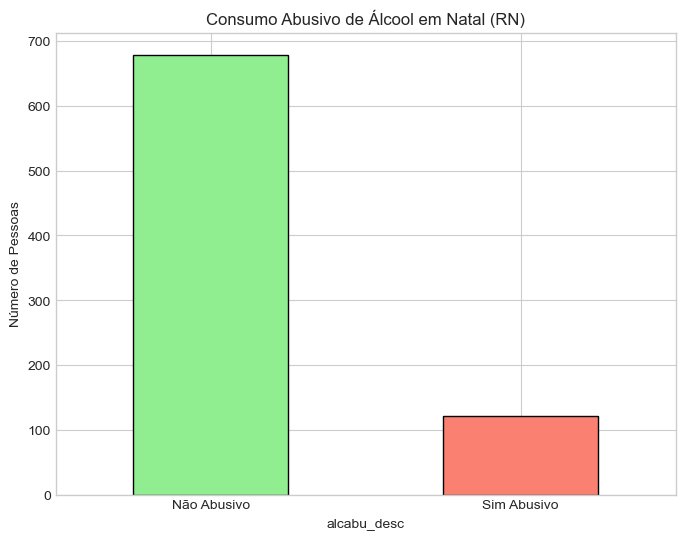

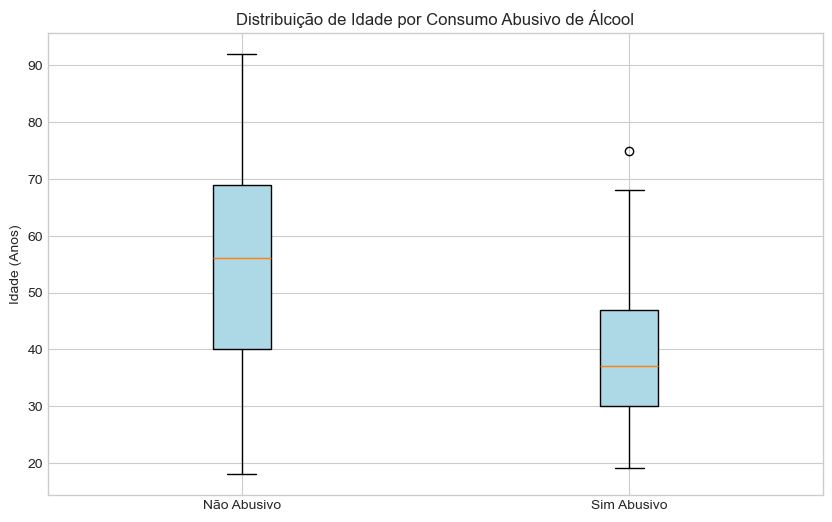

In [37]:
# --- CÉLULA DE ANÁLISE QUANTITATIVA (USANDO O DF_NATAL_FINAL DA MEMÓRIA) ---
import matplotlib.pyplot as plt
import pandas as pd

# Verificar se a variável df_natal_final existe
try:
    len(df_natal_final)
    print(f"DataFrame 'df_natal_final' (com {len(df_natal_final)} linhas) encontrado na memória.")
except NameError:
    print("❌ ERRO: 'df_natal_final' não está na memória. Por favor, execute a célula anterior que o cria (a 'CÉLULA DE TRATAMENTO FINAL E FILTRO')")
    # Este bloco será interrompido se 'df_natal_final' não existir
    raise

# --- PASSO 1: DECODIFICAR VARIÁVEIS (METADADOS) ---
print("Decodificando as variáveis categóricas...")
df_natal_final['sexo_desc'] = df_natal_final['q7'].map({1: 'Masculino', 2: 'Feminino'})
df_natal_final['fumante_desc'] = df_natal_final['fumante'].map({0: 'Não Fuma', 1: 'Fuma'})
df_natal_final['alcabu_desc'] = df_natal_final['alcabu'].map({0: 'Não Abusivo', 1: 'Sim Abusivo'})
df_natal_final['upp_desc'] = df_natal_final['score_upp_2cat'].map({0: 'Baixo Consumo UP', 1: 'Alto Consumo UP'})
df_natal_final['flvreg_desc'] = df_natal_final['flvreg'].map({0: 'Não Consome Hortaliças Reg.', 1: 'Consome Hortaliças Reg.'})
df_natal_final['feijao5_desc'] = df_natal_final['feijao5'].map({0: 'Não Come Feijão 5x/sem', 1: 'Come Feijão 5x/sem'})

# --- PASSO 2: METODOLOGIA - ESTATÍSTICA DESCRITIVA (Páginas 94-114 do PDF) ---
print("\n--- 2.1: Medidas de Posição Central e Dispersão (para 'Idade') ---")
# .describe() gera Média, Mediana (50%), Quartis (25%, 75%), Min, Max, Desvio Padrão
estatisticas_idade = df_natal_final['q6'].describe()
display(estatisticas_idade)

print("\n--- 2.2: Tabela de Frequência (para 'Consumo Abusivo de Álcool') ---")
# .value_counts() gera a Tabela de Frequência
freq_alcool = df_natal_final['alcabu_desc'].value_counts()
print(freq_alcool)

print("\n--- 2.3: Tabela de Frequência (para 'Consumo de Ultraprocessados') ---")
freq_upp = df_natal_final['upp_desc'].value_counts()
print(freq_upp)

# --- PASSO 3: METODOLOGIA - GRÁFICOS (Páginas 124-149 do PDF) ---
print("\n--- 3.1: Gerando Histograma (Idade) ---")
plt.figure(figsize=(10, 6))
plt.hist(df_natal_final['q6'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição de Idade em Natal (RN)')
plt.xlabel('Idade (Anos)')
plt.ylabel('Frequência')
plt.savefig('histograma_idade_final.png')
print("Salvo como 'histograma_idade_final.png'")

print("\n--- 3.2: Gerando Gráfico de Barras (Consumo de Álcool) ---")
plt.figure(figsize=(8, 6))
freq_alcool.plot(kind='bar', color=['lightgreen', 'salmon'], edgecolor='black')
plt.title('Consumo Abusivo de Álcool em Natal (RN)')
plt.ylabel('Número de Pessoas')
plt.xticks(rotation=0)
plt.savefig('barras_alcool_final.png')
print("Salvo como 'barras_alcool_final.png'")

print("\n--- 3.3: Gerando Boxplot (Idade vs. Consumo de Álcool) ---")
plt.figure(figsize=(10, 6))
dados_boxplot = [
    df_natal_final[df_natal_final['alcabu_desc'] == 'Não Abusivo']['q6'].dropna(),
    df_natal_final[df_natal_final['alcabu_desc'] == 'Sim Abusivo']['q6'].dropna()
]
plt.boxplot(dados_boxplot, labels=['Não Abusivo', 'Sim Abusivo'], patch_artist=True,
            boxprops=dict(facecolor='lightblue'))
plt.title('Distribuição de Idade por Consumo Abusivo de Álcool')
plt.ylabel('Idade (Anos)')
plt.savefig('boxplot_idade_vs_alcool.png')
print("Salvo como 'boxplot_idade_vs_alcool.png'")

print("\nAnálise quantitativa concluída com sucesso.")

Iniciando o processo para adicionar a coluna 'imc'...
Carregando o arquivo original 'Vitigel_2023.xlsx'...
Arquivo original carregado com sucesso.
Dados de Natal (antes do tratamento de 'imc'): 800 linhas.
Dados de Natal (APÓS tratamento de 'imc'): 744 linhas.
Colunas renomeadas para o padrão amigável.
Gerando o gráfico de dispersão 'Idade vs. IMC'...
Gráfico salvo como 'dispersao_idade_imc_final.png'
Novo CSV salvo como 'dados_vigitel_natal_FINAL_com_IMC.csv'

--- Pré-visualização do Novo DataFrame Final ---


,cidade,idade,sexo,fumante,alcool_abuso,ultrapro,frutas_legumes_verduras_regular,feijao_5_ou_mais_dias_sem,imc
120,24,40,1,0,0,0,0,1,26.446281
131,24,24,1,0,0,1,0,1,32.000000
142,24,32,1,0,1,0,0,0,35.086182
160,24,35,1,0,1,0,1,0,34.112354
161,24,32,1,0,1,0,0,1,28.081633


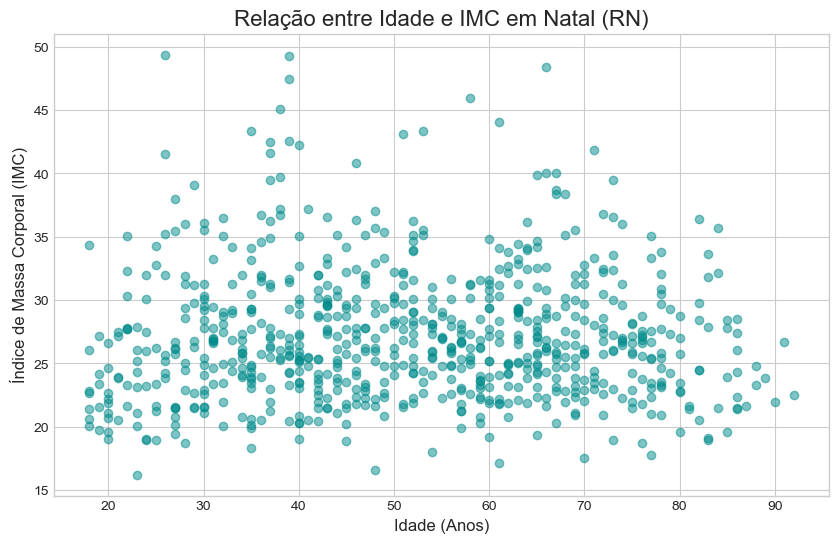

In [38]:
# --- CÉLULA COMPLETA PARA GERAR O DATAFRAME COM IMC ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Iniciando o processo para adicionar a coluna 'imc'...")

try:
    # --- PASSO 1: CARREGAR O ARQUIVO EXCEL ORIGINAL ---
    # O nome exato da sua lista de arquivos é 'Vitigel_2023.xlsx'
    nome_arquivo_excel = 'Vitigel_2023.xlsx'
    
    print(f"Carregando o arquivo original '{nome_arquivo_excel}'...")
    df_vigitel_completo = pd.read_excel(nome_arquivo_excel)
    print("Arquivo original carregado com sucesso.")

    # --- PASSO 2: SELECIONAR COLUNAS (INCLUINDO 'imc') ---
    colunas_finais_com_imc = [
        'cidade', 'q6', 'q7', 'fumante', 'alcabu', 
        'score_upp_2cat', 'flvreg', 'feijao5', 'imc'
    ]
    
    df_foco_com_imc = df_vigitel_completo[colunas_finais_com_imc].copy()

    # --- PASSO 3: FILTRAR PARA NATAL (RN) ---
    CODIGO_NATAL = 24
    df_natal_com_imc = df_foco_com_imc[df_foco_com_imc['cidade'] == CODIGO_NATAL].copy()
    print(f"Dados de Natal (antes do tratamento de 'imc'): {len(df_natal_com_imc)} linhas.")

    # --- PASSO 4: TRATAMENTO METODOLÓGICO DA COLUNA 'imc' ---
    # Deletar amostras (linhas) com dados faltantes em 'imc'
    df_natal_com_imc.dropna(subset=['imc'], inplace=True)
    
    # Deletar outliers (valores implausíveis)
    df_natal_com_imc = df_natal_com_imc[
        (df_natal_com_imc['imc'] > 10) & (df_natal_com_imc['imc'] < 60)
    ]
    # NOTA: Seu DataFrame de 800 linhas será reduzido aqui, pois estamos
    # removendo pessoas que não tinham um IMC válido.
    print(f"Dados de Natal (APÓS tratamento de 'imc'): {len(df_natal_com_imc)} linhas.")

    # --- PASSO 5: RENOMEAR COLUNAS (PARA O PADRÃO AMIGÁVEL) ---
    mapa_nomes = {
        'q6': 'idade',
        'q7': 'sexo',
        'alcabu': 'alcool_abuso',
        'score_upp_2cat': 'ultrapro',
        'flvreg': 'frutas_legumes_verduras_regular',
        'feijao5': 'feijao_5_ou_mais_dias_sem'
        # 'cidade' e 'imc' já estão com nomes bons
    }
    df_natal_final_com_imc = df_natal_com_imc.rename(columns=mapa_nomes)
    
    print("Colunas renomeadas para o padrão amigável.")

    # --- PASSO 6: GERAR O GRÁFICO DE DISPERSÃO ESTRATÉGICO ---
    print("Gerando o gráfico de dispersão 'Idade vs. IMC'...")
    plt.figure(figsize=(10, 6))
    plt.scatter(
        df_natal_final_com_imc['idade'],  # Eixo X
        df_natal_final_com_imc['imc'],    # Eixo Y
        alpha=0.5,
        color='darkcyan'
    )
    plt.title('Relação entre Idade e IMC em Natal (RN)', fontsize=16)
    plt.xlabel('Idade (Anos)', fontsize=12)
    plt.ylabel('Índice de Massa Corporal (IMC)', fontsize=12)
    plt.grid(True)
    plt.savefig('dispersao_idade_imc_final.png')
    print("Gráfico salvo como 'dispersao_idade_imc_final.png'")

    # --- PASSO 7: SALVAR O NOVO CSV (O ARQUIVO QUE VOCÊ QUER) ---
    nome_arquivo_novo_csv = 'dados_vigitel_natal_FINAL_com_IMC.csv'
    df_natal_final_com_imc.to_csv(nome_arquivo_novo_csv, index=False, encoding='utf-8-sig')
    print(f"Novo CSV salvo como '{nome_arquivo_novo_csv}'")
    
    print("\n--- Pré-visualização do Novo DataFrame Final ---")
    display(df_natal_final_com_imc.head())

except FileNotFoundError:
    print(f"❌ ERRO: Não encontrei o arquivo original 'Vitigel_2023.xlsx'.")
    print("Isso é estranho, pois ele estava na sua lista. Verifique se o nome está 100% idêntico (maiúsculas/minúsculas).")
except KeyError as e:
    print(f"❌ ERRO de Chave (Coluna): {e}. Uma das colunas não foi encontrada no arquivo original.")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado: {e}")